In [1]:
!pip install xgboost

import pandas as pd
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("--- Script Started ---")

--- Script Started ---


In [3]:
from google.colab import files
files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle -q

# # Download and unzip competition data
# !kaggle competitions download -c ait-511-course-project-1-obesity-risk
# !unzip -q ait-511-course-project-1-obesity-risk.zip -d data


Saving ObesityDataSet.csv to ObesityDataSet.csv
Saving kaggle.json to kaggle.json
Saving train.csv to train.csv
Saving test.csv to test.csv
Saving sample_submission.csv to sample_submission.csv


In [4]:
# --- Step 1: Load All Datasets ---
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    original_df = pd.read_csv("ObesityDataSet.csv")
    print("All files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    print("Please make sure train.csv, test.csv, and ObesityDataSet.csv are in the same directory.")
    exit()

All files loaded successfully.


In [5]:
# --- Step 2: Combine and Clean Training Data ---
print("Combining and cleaning training data...")

# 1. Rename the target column
original_df.rename(columns={'NObeyesdad': 'WeightCategory'}, inplace=True)

# 2. Drop the 'id' column from the training set
train_df_no_id = train_df.drop('id', axis=1)

# 3. Concatenate the two training dataframes
combined_df = pd.concat([train_df_no_id, original_df], ignore_index=True)

# 4. Drop duplicate rows
duplicate_count = combined_df.duplicated().sum()
combined_df.drop_duplicates(inplace=True)
print(f"Dropped {duplicate_count} duplicate rows.")
print(f"Combined training data shape: {combined_df.shape}")

# --- Step 3: Prepare Data for Modeling (Features X, Target y) ---
print("Preparing data for modeling...")

# 1. Separate features (X) and the raw target (y_raw)
X = combined_df.drop('WeightCategory', axis=1)
y_raw = combined_df['WeightCategory']

# 2. Encode the target variable (y) into numbers (0, 1, 2...)
# XGBoost needs numeric labels starting from 0
le = LabelEncoder()
y = le.fit_transform(y_raw)

# 3. Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")

# --- Step 4: Define Preprocessing Pipeline ---
print("Defining preprocessing pipeline...")

Combining and cleaning training data...
Dropped 24 duplicate rows.
Combined training data shape: (17620, 17)
Preparing data for modeling...
Training set size: 14096, Validation set size: 3524
Defining preprocessing pipeline...


In [6]:
# 1. Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Categorical features identified: {len(categorical_features)}")

# 2. Create the transformer for numerical features (Scaling)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3. Create the transformer for categorical features (One-Hot Encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4. Combine these transformers into a single 'preprocessor'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- Step 5: Define XGBoost Model with Specific Parameters ---
print("Defining XGBoost model with provided parameters...")

Numerical features identified: 8
Categorical features identified: 8
Defining XGBoost model with provided parameters...


In [23]:
!pip install optuna -q

import optuna
import json
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Ensure LabelEncoder is imported if not already
import pandas as pd # Import pandas
from sklearn.compose import ColumnTransformer # Import ColumnTransformer
from sklearn.pipeline import Pipeline # Import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Import necessary preprocessors
from sklearn.exceptions import NotFittedError # Import NotFittedError

print("\n--- Starting Optuna Tuning (Refined Search Around Best Params) ---")

# Ensure train/val split exists and preprocessor is defined
# Assuming X, y, X_train, X_val, y_train, y_val, preprocessor, categorical_features are already defined

# --- Define Objective Function ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1200, 1800),              # around 1513
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.02),        # around 0.0124
        'max_depth': trial.suggest_int('max_depth', 8, 12),                        # around 10
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 6),           # around 4
        'gamma': trial.suggest_float('gamma', 0.3, 0.8),                           # around 0.53
        'subsample': trial.suggest_float('subsample', 0.6, 0.75),                  # around 0.67
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.45, 0.6),    # around 0.50
        'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 0.8),                   # around 0.61
        'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 1.0),                 # around 0.91
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'n_jobs': -1,
    }

    model = xgb.XGBClassifier(**params)

    # Explicitly convert categorical columns to 'category' dtype before transforming
    # Operate on copies to avoid modifying the original X_train/X_val DataFrames
    X_train_temp = X_train.copy()
    X_val_temp = X_val.copy()

    for col in categorical_features:
        X_train_temp[col] = X_train_temp[col].astype('category')
        X_val_temp[col] = X_val_temp[col].astype('category')

    # Apply the preprocessor (already fitted outside)
    X_train_proc = preprocessor.transform(X_train_temp)
    X_val_proc = preprocessor.transform(X_val_temp)

    model.fit(X_train_proc, y_train)
    preds = model.predict(X_val_proc)
    acc = accuracy_score(y_val, preds)

    print(f"Trial {trial.number}: Accuracy = {acc:.5f}")
    return acc

# --- Run Optimization ---

try:
    preprocessor.transform(X_train.head(1)) # Attempt transform to check if fitted
    print("Preprocessor already fitted.")
except NotFittedError:
    print("Fitting preprocessor...")
    preprocessor.fit(X_train)
    print("Preprocessor fitted.")
except NameError:
     print("Preprocessor not defined. Please ensure preprocessor is defined in a previous cell.")
     exit()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Reduced trials for demonstration

print("\n--- Optuna Optimization Complete ---")
print(f"Best Validation Accuracy: {study.best_value:.5f}")
print("Best Hyperparameters:")
print(study.best_params)

[I 2025-10-26 11:27:44,818] A new study created in memory with name: no-name-2c68cd37-f545-4463-b108-9c376ce5d30c



--- Starting Optuna Tuning (Refined Search Around Best Params) ---
Preprocessor already fitted.


[I 2025-10-26 11:28:11,007] Trial 0 finished with value: 0.9213961407491487 and parameters: {'n_estimators': 1496, 'learning_rate': 0.01031835883819037, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.7260921162238934, 'subsample': 0.6050147061572234, 'colsample_bytree': 0.5700341607606437, 'reg_alpha': 0.5429884254241379, 'reg_lambda': 0.9057386882822237}. Best is trial 0 with value: 0.9213961407491487.


Trial 0: Accuracy = 0.92140


[I 2025-10-26 11:28:36,926] Trial 1 finished with value: 0.9196935300794552 and parameters: {'n_estimators': 1399, 'learning_rate': 0.011986275824312536, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.43514986583330145, 'subsample': 0.6566974719600327, 'colsample_bytree': 0.5973551881443357, 'reg_alpha': 0.47986601334627443, 'reg_lambda': 0.9817632070877018}. Best is trial 0 with value: 0.9213961407491487.


Trial 1: Accuracy = 0.91969


[I 2025-10-26 11:28:59,203] Trial 2 finished with value: 0.9202610669693531 and parameters: {'n_estimators': 1571, 'learning_rate': 0.01935135561943295, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.7085840495228268, 'subsample': 0.6030590839122215, 'colsample_bytree': 0.5423340073453058, 'reg_alpha': 0.5316678975763637, 'reg_lambda': 0.8287552113156498}. Best is trial 0 with value: 0.9213961407491487.


Trial 2: Accuracy = 0.92026


[I 2025-10-26 11:29:31,088] Trial 3 finished with value: 0.9194097616345063 and parameters: {'n_estimators': 1796, 'learning_rate': 0.013954764846456882, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.32855934083125576, 'subsample': 0.6029483459609164, 'colsample_bytree': 0.4829485804709746, 'reg_alpha': 0.5548889995835655, 'reg_lambda': 0.9910570790693466}. Best is trial 0 with value: 0.9213961407491487.


Trial 3: Accuracy = 0.91941


[I 2025-10-26 11:29:51,261] Trial 4 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1274, 'learning_rate': 0.015239911274393204, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.5971757004029002, 'subsample': 0.7326780792686094, 'colsample_bytree': 0.4909080089706558, 'reg_alpha': 0.5574590247541422, 'reg_lambda': 0.8931217697952036}. Best is trial 4 with value: 0.9228149829738933.


Trial 4: Accuracy = 0.92281


[I 2025-10-26 11:30:18,365] Trial 5 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1783, 'learning_rate': 0.011125472978048006, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.7200255216829214, 'subsample': 0.7313758421498151, 'colsample_bytree': 0.45038290114262775, 'reg_alpha': 0.5989918860656528, 'reg_lambda': 0.9882578683766929}. Best is trial 5 with value: 0.9233825198637912.


Trial 5: Accuracy = 0.92338


[I 2025-10-26 11:30:47,665] Trial 6 finished with value: 0.9205448354143019 and parameters: {'n_estimators': 1614, 'learning_rate': 0.01352033749884353, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.36496170350390394, 'subsample': 0.677708426846392, 'colsample_bytree': 0.5355878005304243, 'reg_alpha': 0.7006781900987022, 'reg_lambda': 0.8116376790347049}. Best is trial 5 with value: 0.9233825198637912.


Trial 6: Accuracy = 0.92054


[I 2025-10-26 11:31:13,139] Trial 7 finished with value: 0.9205448354143019 and parameters: {'n_estimators': 1304, 'learning_rate': 0.013205557861326381, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.3263866646971366, 'subsample': 0.7234163249160741, 'colsample_bytree': 0.5273306360195354, 'reg_alpha': 0.49967481091853, 'reg_lambda': 0.987051620401753}. Best is trial 5 with value: 0.9233825198637912.


Trial 7: Accuracy = 0.92054


[I 2025-10-26 11:31:32,708] Trial 8 finished with value: 0.9219636776390465 and parameters: {'n_estimators': 1334, 'learning_rate': 0.016581634001356364, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.6757999570687433, 'subsample': 0.697172592580535, 'colsample_bytree': 0.552087264727877, 'reg_alpha': 0.6394801445228174, 'reg_lambda': 0.9115190772574822}. Best is trial 5 with value: 0.9233825198637912.


Trial 8: Accuracy = 0.92196


[I 2025-10-26 11:31:56,177] Trial 9 finished with value: 0.9230987514188422 and parameters: {'n_estimators': 1503, 'learning_rate': 0.018126240671999465, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.43202231558937004, 'subsample': 0.7126968108897013, 'colsample_bytree': 0.46052564572021787, 'reg_alpha': 0.715751968569228, 'reg_lambda': 0.8315833932343417}. Best is trial 5 with value: 0.9233825198637912.


Trial 9: Accuracy = 0.92310


[I 2025-10-26 11:32:25,435] Trial 10 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1776, 'learning_rate': 0.008141316884054839, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.794977176794633, 'subsample': 0.7401281325260428, 'colsample_bytree': 0.45129437377930676, 'reg_alpha': 0.40161099213234336, 'reg_lambda': 0.9439962182674747}. Best is trial 5 with value: 0.9233825198637912.


Trial 10: Accuracy = 0.92338


[I 2025-10-26 11:32:55,056] Trial 11 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1794, 'learning_rate': 0.008969178021694632, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.7919789349133864, 'subsample': 0.7498290099114181, 'colsample_bytree': 0.4577780464707329, 'reg_alpha': 0.40312394374473803, 'reg_lambda': 0.9471292715462853}. Best is trial 5 with value: 0.9233825198637912.


Trial 11: Accuracy = 0.92338


[I 2025-10-26 11:33:23,586] Trial 12 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1695, 'learning_rate': 0.008165643069015733, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.799095508211782, 'subsample': 0.7490483698386435, 'colsample_bytree': 0.48605550393296154, 'reg_alpha': 0.7740692113467154, 'reg_lambda': 0.9487659151694655}. Best is trial 5 with value: 0.9233825198637912.


Trial 12: Accuracy = 0.92281


[I 2025-10-26 11:33:51,639] Trial 13 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1710, 'learning_rate': 0.01096844097319455, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.6194106314116357, 'subsample': 0.6978840445796382, 'colsample_bytree': 0.5044020889429703, 'reg_alpha': 0.40025004562789995, 'reg_lambda': 0.9479533241027198}. Best is trial 5 with value: 0.9233825198637912.


Trial 13: Accuracy = 0.92281


[I 2025-10-26 11:34:20,698] Trial 14 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1696, 'learning_rate': 0.009221666831824018, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.5407982988734834, 'subsample': 0.6613613178718291, 'colsample_bytree': 0.4512926010048281, 'reg_alpha': 0.629286475374649, 'reg_lambda': 0.9642261508783605}. Best is trial 14 with value: 0.9236662883087401.


Trial 14: Accuracy = 0.92367


[I 2025-10-26 11:34:49,898] Trial 15 finished with value: 0.9230987514188422 and parameters: {'n_estimators': 1672, 'learning_rate': 0.01010968058033607, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.5403048411802749, 'subsample': 0.6444665015317952, 'colsample_bytree': 0.47109623877835544, 'reg_alpha': 0.6309118209527601, 'reg_lambda': 0.9993191725489765}. Best is trial 14 with value: 0.9236662883087401.


Trial 15: Accuracy = 0.92310


[I 2025-10-26 11:35:17,194] Trial 16 finished with value: 0.9202610669693531 and parameters: {'n_estimators': 1620, 'learning_rate': 0.011953699030716506, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.503236562271578, 'subsample': 0.6478281897709486, 'colsample_bytree': 0.5018513462289761, 'reg_alpha': 0.6080219898260337, 'reg_lambda': 0.8676002468915054}. Best is trial 14 with value: 0.9236662883087401.


Trial 16: Accuracy = 0.92026


[I 2025-10-26 11:35:45,961] Trial 17 finished with value: 0.9225312145289444 and parameters: {'n_estimators': 1718, 'learning_rate': 0.009463555907051868, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.6146004433929015, 'subsample': 0.628812203268772, 'colsample_bytree': 0.5140902260566701, 'reg_alpha': 0.6679262265409506, 'reg_lambda': 0.9641359388658658}. Best is trial 14 with value: 0.9236662883087401.


Trial 17: Accuracy = 0.92253


[I 2025-10-26 11:36:12,251] Trial 18 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1530, 'learning_rate': 0.01176029911197526, 'max_depth': 11, 'min_child_weight': 6, 'gamma': 0.4843734108591136, 'subsample': 0.679144793392751, 'colsample_bytree': 0.47212358947281857, 'reg_alpha': 0.7991822388814684, 'reg_lambda': 0.9671555638734881}. Best is trial 14 with value: 0.9236662883087401.


Trial 18: Accuracy = 0.92281


[I 2025-10-26 11:36:39,344] Trial 19 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1647, 'learning_rate': 0.011015467030147677, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.5617639403986493, 'subsample': 0.6651840006854242, 'colsample_bytree': 0.466572966586164, 'reg_alpha': 0.5888518777229654, 'reg_lambda': 0.9203490195739233}. Best is trial 14 with value: 0.9236662883087401.


Trial 19: Accuracy = 0.92338


[I 2025-10-26 11:37:03,350] Trial 20 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1735, 'learning_rate': 0.015636680980032507, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.658278094340536, 'subsample': 0.6931053278098878, 'colsample_bytree': 0.450260767716944, 'reg_alpha': 0.7249405487850983, 'reg_lambda': 0.8792326549447592}. Best is trial 14 with value: 0.9236662883087401.


Trial 20: Accuracy = 0.92367


[I 2025-10-26 11:37:27,946] Trial 21 finished with value: 0.9225312145289444 and parameters: {'n_estimators': 1742, 'learning_rate': 0.015200016669841153, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 0.6633892503472464, 'subsample': 0.695895513914456, 'colsample_bytree': 0.45347186315644467, 'reg_alpha': 0.72114163474241, 'reg_lambda': 0.8686815294883179}. Best is trial 14 with value: 0.9236662883087401.


Trial 21: Accuracy = 0.92253


[I 2025-10-26 11:37:45,805] Trial 22 finished with value: 0.9230987514188422 and parameters: {'n_estimators': 1203, 'learning_rate': 0.015469346191817598, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.7415125595709888, 'subsample': 0.717046003836324, 'colsample_bytree': 0.47478442621403144, 'reg_alpha': 0.6736877405770335, 'reg_lambda': 0.8780478798504826}. Best is trial 14 with value: 0.9236662883087401.


Trial 22: Accuracy = 0.92310


[I 2025-10-26 11:38:09,199] Trial 23 finished with value: 0.924233825198638 and parameters: {'n_estimators': 1745, 'learning_rate': 0.017329387191492827, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.6638998869473484, 'subsample': 0.6838434055207704, 'colsample_bytree': 0.46329884371666763, 'reg_alpha': 0.7498770938356636, 'reg_lambda': 0.9265712959463885}. Best is trial 23 with value: 0.924233825198638.


Trial 23: Accuracy = 0.92423


[I 2025-10-26 11:38:33,140] Trial 24 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1736, 'learning_rate': 0.01731663873132585, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.6434527343276377, 'subsample': 0.6868279645287685, 'colsample_bytree': 0.49481773270375307, 'reg_alpha': 0.7630085042302686, 'reg_lambda': 0.9254873793599337}. Best is trial 23 with value: 0.924233825198638.


Trial 24: Accuracy = 0.92281


[I 2025-10-26 11:38:54,429] Trial 25 finished with value: 0.923950056753689 and parameters: {'n_estimators': 1431, 'learning_rate': 0.019981456320233695, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.5688578469588738, 'subsample': 0.6670241307084749, 'colsample_bytree': 0.4789595512273446, 'reg_alpha': 0.7385176841564797, 'reg_lambda': 0.8475080196172949}. Best is trial 23 with value: 0.924233825198638.


Trial 25: Accuracy = 0.92395


[I 2025-10-26 11:39:13,877] Trial 26 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1424, 'learning_rate': 0.01979773004473275, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.572720058774094, 'subsample': 0.6671565412876427, 'colsample_bytree': 0.4791212547105583, 'reg_alpha': 0.7581167362003216, 'reg_lambda': 0.8450260187397031}. Best is trial 23 with value: 0.924233825198638.


Trial 26: Accuracy = 0.92367


[I 2025-10-26 11:39:36,132] Trial 27 finished with value: 0.9222474460839954 and parameters: {'n_estimators': 1385, 'learning_rate': 0.018719203491246242, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.5195341686428203, 'subsample': 0.6281144312577475, 'colsample_bytree': 0.514160205340238, 'reg_alpha': 0.6783813340567768, 'reg_lambda': 0.9297320454217466}. Best is trial 23 with value: 0.924233825198638.


Trial 27: Accuracy = 0.92225


[I 2025-10-26 11:39:59,581] Trial 28 finished with value: 0.9230987514188422 and parameters: {'n_estimators': 1462, 'learning_rate': 0.017699504115078875, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.46364816421057864, 'subsample': 0.6331636933761958, 'colsample_bytree': 0.4651338331597495, 'reg_alpha': 0.7983609255373925, 'reg_lambda': 0.8031047935791235}. Best is trial 23 with value: 0.924233825198638.


Trial 28: Accuracy = 0.92310


[I 2025-10-26 11:40:23,711] Trial 29 finished with value: 0.9222474460839954 and parameters: {'n_estimators': 1552, 'learning_rate': 0.016816059656904216, 'max_depth': 10, 'min_child_weight': 5, 'gamma': 0.5809684807219238, 'subsample': 0.6173817761909728, 'colsample_bytree': 0.5684266768397112, 'reg_alpha': 0.7458866848749968, 'reg_lambda': 0.898335490342651}. Best is trial 23 with value: 0.924233825198638.


Trial 29: Accuracy = 0.92225


[I 2025-10-26 11:40:46,150] Trial 30 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1464, 'learning_rate': 0.01871229285225662, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.535329309452125, 'subsample': 0.6652555539070605, 'colsample_bytree': 0.49785991899340576, 'reg_alpha': 0.6489234356777841, 'reg_lambda': 0.9682029438847496}. Best is trial 23 with value: 0.924233825198638.


Trial 30: Accuracy = 0.92367


[I 2025-10-26 11:41:07,816] Trial 31 finished with value: 0.9245175936435869 and parameters: {'n_estimators': 1661, 'learning_rate': 0.01602609869354831, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.6845093394490588, 'subsample': 0.6891201284370663, 'colsample_bytree': 0.46546749003718135, 'reg_alpha': 0.7236095552936783, 'reg_lambda': 0.8484772555758006}. Best is trial 31 with value: 0.9245175936435869.


Trial 31: Accuracy = 0.92452


[I 2025-10-26 11:41:31,022] Trial 32 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1614, 'learning_rate': 0.01626376489512493, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.6924643690328043, 'subsample': 0.6504443133872316, 'colsample_bytree': 0.4632724546784666, 'reg_alpha': 0.6948459079096607, 'reg_lambda': 0.8535973597230379}. Best is trial 31 with value: 0.9245175936435869.


Trial 32: Accuracy = 0.92281


[I 2025-10-26 11:41:57,383] Trial 33 finished with value: 0.9213961407491487 and parameters: {'n_estimators': 1672, 'learning_rate': 0.014494496671500007, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.741056600836737, 'subsample': 0.7079038421115174, 'colsample_bytree': 0.591879421009274, 'reg_alpha': 0.7315590152049227, 'reg_lambda': 0.8480699014020473}. Best is trial 31 with value: 0.9245175936435869.


Trial 33: Accuracy = 0.92140


[I 2025-10-26 11:42:19,888] Trial 34 finished with value: 0.9222474460839954 and parameters: {'n_estimators': 1577, 'learning_rate': 0.019068431548019633, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.6226264303323551, 'subsample': 0.6847959476799804, 'colsample_bytree': 0.4786721716550733, 'reg_alpha': 0.6996962290391625, 'reg_lambda': 0.9057866585664713}. Best is trial 31 with value: 0.9245175936435869.


Trial 34: Accuracy = 0.92225


[I 2025-10-26 11:42:42,755] Trial 35 finished with value: 0.9225312145289444 and parameters: {'n_estimators': 1379, 'learning_rate': 0.01973435630669892, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.40628427559037994, 'subsample': 0.6706696839919805, 'colsample_bytree': 0.4860021404018764, 'reg_alpha': 0.7755115379079145, 'reg_lambda': 0.8250712288198973}. Best is trial 31 with value: 0.9245175936435869.


Trial 35: Accuracy = 0.92253


[I 2025-10-26 11:43:06,677] Trial 36 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1661, 'learning_rate': 0.01812203515733329, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.5924403820877956, 'subsample': 0.6570448945145149, 'colsample_bytree': 0.4600524735588762, 'reg_alpha': 0.743771981468406, 'reg_lambda': 0.8868023496755643}. Best is trial 31 with value: 0.9245175936435869.


Trial 36: Accuracy = 0.92338


[I 2025-10-26 11:43:32,185] Trial 37 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1761, 'learning_rate': 0.012794721315717943, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.7593469244014653, 'subsample': 0.6581838134056488, 'colsample_bytree': 0.4890828886574199, 'reg_alpha': 0.6590241286108194, 'reg_lambda': 0.8582092053104453}. Best is trial 31 with value: 0.9245175936435869.


Trial 37: Accuracy = 0.92338


[I 2025-10-26 11:43:54,385] Trial 38 finished with value: 0.9250851305334846 and parameters: {'n_estimators': 1597, 'learning_rate': 0.01452211141490541, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6985265792741071, 'subsample': 0.7050056223404357, 'colsample_bytree': 0.4686281411833096, 'reg_alpha': 0.5740823340642535, 'reg_lambda': 0.832267917170442}. Best is trial 38 with value: 0.9250851305334846.


Trial 38: Accuracy = 0.92509


[I 2025-10-26 11:44:17,160] Trial 39 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1595, 'learning_rate': 0.015919685137706, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6968699585922729, 'subsample': 0.7033824897643698, 'colsample_bytree': 0.47133835538486274, 'reg_alpha': 0.5152620453149217, 'reg_lambda': 0.8339328059914278}. Best is trial 38 with value: 0.9250851305334846.


Trial 39: Accuracy = 0.92367


[I 2025-10-26 11:44:40,733] Trial 40 finished with value: 0.924233825198638 and parameters: {'n_estimators': 1532, 'learning_rate': 0.014344530296817717, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.7165750279617984, 'subsample': 0.6866249575292788, 'colsample_bytree': 0.5064931091917587, 'reg_alpha': 0.581960622533727, 'reg_lambda': 0.8179920256742877}. Best is trial 38 with value: 0.9250851305334846.


Trial 40: Accuracy = 0.92423


[I 2025-10-26 11:45:04,161] Trial 41 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1532, 'learning_rate': 0.014561321077327516, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.7197734390933277, 'subsample': 0.6865293209475655, 'colsample_bytree': 0.5113398287815695, 'reg_alpha': 0.5708333345480892, 'reg_lambda': 0.8151093843934085}. Best is trial 38 with value: 0.9250851305334846.


Trial 41: Accuracy = 0.92338


[I 2025-10-26 11:45:27,299] Trial 42 finished with value: 0.923950056753689 and parameters: {'n_estimators': 1470, 'learning_rate': 0.014108769510254578, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6838896096291427, 'subsample': 0.6811442034332624, 'colsample_bytree': 0.4797857278409636, 'reg_alpha': 0.5664643101545425, 'reg_lambda': 0.8205400952132935}. Best is trial 38 with value: 0.9250851305334846.


Trial 42: Accuracy = 0.92395


[I 2025-10-26 11:45:48,569] Trial 43 finished with value: 0.9216799091940976 and parameters: {'n_estimators': 1416, 'learning_rate': 0.013080800019219976, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.7597357727783098, 'subsample': 0.7051117712842238, 'colsample_bytree': 0.5217988094745424, 'reg_alpha': 0.5351515806001329, 'reg_lambda': 0.8368086232093906}. Best is trial 38 with value: 0.9250851305334846.


Trial 43: Accuracy = 0.92168


[I 2025-10-26 11:46:11,852] Trial 44 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1507, 'learning_rate': 0.014798499875878583, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6445701050856059, 'subsample': 0.6755076131489072, 'colsample_bytree': 0.4678107791328268, 'reg_alpha': 0.4551801206900728, 'reg_lambda': 0.8048153987442884}. Best is trial 38 with value: 0.9250851305334846.


Trial 44: Accuracy = 0.92281


[I 2025-10-26 11:46:34,935] Trial 45 finished with value: 0.9213961407491487 and parameters: {'n_estimators': 1643, 'learning_rate': 0.01690808943512575, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.7169825575579095, 'subsample': 0.7211532310366925, 'colsample_bytree': 0.5393523581815058, 'reg_alpha': 0.609146277095852, 'reg_lambda': 0.8135931962592448}. Best is trial 38 with value: 0.9250851305334846.


Trial 45: Accuracy = 0.92140


[I 2025-10-26 11:46:57,670] Trial 46 finished with value: 0.9228149829738933 and parameters: {'n_estimators': 1572, 'learning_rate': 0.01619980107732592, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.7661921822544228, 'subsample': 0.692999308732841, 'colsample_bytree': 0.5300724653097624, 'reg_alpha': 0.5469574719150998, 'reg_lambda': 0.8423215637348564}. Best is trial 38 with value: 0.9250851305334846.


Trial 46: Accuracy = 0.92281


[I 2025-10-26 11:47:21,559] Trial 47 finished with value: 0.9233825198637912 and parameters: {'n_estimators': 1543, 'learning_rate': 0.013724152317429782, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 0.703872314813843, 'subsample': 0.6724163907112635, 'colsample_bytree': 0.49231104514746304, 'reg_alpha': 0.5857588063005695, 'reg_lambda': 0.857356449847221}. Best is trial 38 with value: 0.9250851305334846.


Trial 47: Accuracy = 0.92338


[I 2025-10-26 11:47:45,698] Trial 48 finished with value: 0.9222474460839954 and parameters: {'n_estimators': 1492, 'learning_rate': 0.012671087868246, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6658876349898837, 'subsample': 0.7112770492269078, 'colsample_bytree': 0.5476419891424117, 'reg_alpha': 0.5035993745877716, 'reg_lambda': 0.8240269122067017}. Best is trial 38 with value: 0.9250851305334846.


Trial 48: Accuracy = 0.92225


[I 2025-10-26 11:48:06,129] Trial 49 finished with value: 0.9236662883087401 and parameters: {'n_estimators': 1334, 'learning_rate': 0.014942468642067778, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.6340883758445197, 'subsample': 0.6996819691011831, 'colsample_bytree': 0.5077995987096731, 'reg_alpha': 0.46975380294573443, 'reg_lambda': 0.8671222336697646}. Best is trial 38 with value: 0.9250851305334846.


Trial 49: Accuracy = 0.92367

--- Optuna Optimization Complete ---
Best Validation Accuracy: 0.92509
Best Hyperparameters:
{'n_estimators': 1597, 'learning_rate': 0.01452211141490541, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6985265792741071, 'subsample': 0.7050056223404357, 'colsample_bytree': 0.4686281411833096, 'reg_alpha': 0.5740823340642535, 'reg_lambda': 0.832267917170442}


In [24]:
xgb_params = study.best_params


==================== XGBoost ====================
Cross-Validation Accuracy: 0.9141
Validation Accuracy: 0.9251
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       428
           1       0.89      0.90      0.90       525
           2       0.93      0.92      0.92       512
           3       0.97      0.99      0.98       540
           4       1.00      1.00      1.00       661
           5       0.84      0.81      0.82       424
           6       0.87      0.86      0.86       434

    accuracy                           0.93      3524
   macro avg       0.92      0.92      0.92      3524
weighted avg       0.92      0.93      0.92      3524



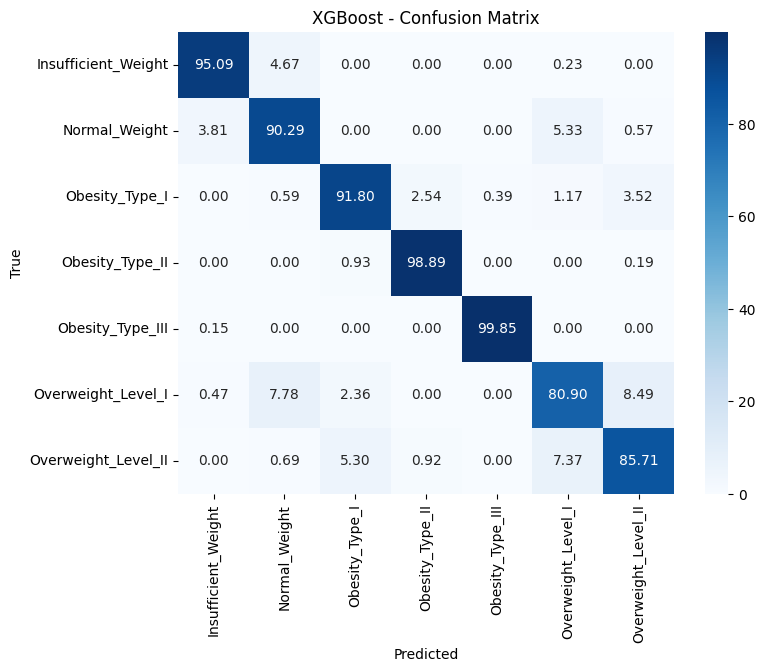

In [39]:
# Correct the import statement for XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np


xgb_params={
    'n_estimators': 1597,
    'learning_rate': 0.01452211141490541,
    'max_depth': 12,
    'min_child_weight': 5,
    'gamma': 0.6985265792741071,
    'subsample': 0.7050056223404357,
    'colsample_bytree': 0.4686281411833096,
    'reg_alpha': 0.5740823340642535,
    'reg_lambda': 0.832267917170442
}

# -------------------------------
# Model dictionary for iteration
# -------------------------------
models = {
    "XGBoost": XGBClassifier(**xgb_params, random_state=42)
}

# -------------------------------
# Preprocess data
# -------------------------------
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# -------------------------------
# Train and evaluate each model
# -------------------------------
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")

    # Cross-validation accuracy
    cv_score = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    print(f"Cross-Validation Accuracy: {cv_score:.4f}")

    # Train the model
    model.fit(X_train_processed, y_train)

    # Predictions
    y_pred = model.predict(X_val_processed)
    y_pred = y_pred.astype(int)

    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

In [25]:
classifier = xgb.XGBClassifier(**xgb_params)

# 2. Create the full pipeline: Preprocessing + Classification
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])
# --- Step 6: Train on Training Set and Validate ---
print("Training model on X_train, y_train...")
full_pipeline.fit(X_train, y_train)

# Validate on the hold-out set
print("Evaluating model on validation set...")
y_pred_val = full_pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)

print(f"Accuracy on validation set (unseen data): {val_accuracy:.5f}")


# --- Step 7: Train Final Model on ALL Data ---
print("Training final model on all combined data (X, y)...")


final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(**xgb_params))
])

final_pipeline.fit(X, y)
print("Final model training complete.")

# --- Step 8: Generate Submission File ---
print("Generating submission file...")

# 1. Prepare the test data (drop 'id')
X_test = test_df.drop('id', axis=1)
test_ids = test_df['id']

Training model on X_train, y_train...
Evaluating model on validation set...
Accuracy on validation set (unseen data): 0.92168
Training final model on all combined data (X, y)...
Final model training complete.
Generating submission file...


In [26]:
# 2. Make predictions on the test set
test_predictions_encoded = final_pipeline.predict(X_test)

# 3. Decode the numeric predictions back into string labels
test_predictions_labels = le.inverse_transform(test_predictions_encoded)

# 4. Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_predictions_labels
})

# 5. Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("\n--- 'submission.csv' created successfully! ---")
print("Submission file head:")
print(submission_df.head())


--- 'submission.csv' created successfully! ---
Submission file head:
      id       WeightCategory
0  15533     Obesity_Type_III
1  15534   Overweight_Level_I
2  15535  Overweight_Level_II
3  15536      Obesity_Type_II
4  15537        Normal_Weight


In [ ]:
-------------------------------------------------------------------#FOR ALL OTHER MODELS----------------------------------------------------------------------

In [ ]:
#########################################################----------RANDOM_FOREST------------##################################################################

In [20]:
!pip install optuna -q
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
import optuna

print("\n--- Starting Optuna Tuning ---")

# --- Ensure preprocessor is fitted ---
try:
    preprocessor.transform(X_train.head(1))
    print("Preprocessor already fitted.")
except NotFittedError:
    print("Fitting preprocessor...")
    preprocessor.fit(X_train)
    print("Preprocessor fitted.")
except NameError:
    print("Preprocessor not defined. Please define preprocessor first.")
    exit()

# --- Objective Functions ---
def objective_rf(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': 42,
    'n_jobs': -1
}

    model = RandomForestClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

def objective_gb(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'subsample': trial.suggest_float('subsample', 0.8, 0.95),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'random_state': 42
}

    model = GradientBoostingClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))


def objective_ada(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'algorithm': trial.suggest_categorical('algorithm', ['SAMME']),
    'random_state': 42
}
    model = AdaBoostClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

# --- Run Optimization ---
model_choice = 'RandomForest'  # change to 'RandomForest' or 'AdaBoost' to switch

if model_choice == 'RandomForest':
    objective = objective_rf
    ModelClass = RandomForestClassifier
elif model_choice == 'GradientBoosting':
    objective = objective_gb
    ModelClass = GradientBoostingClassifier
elif model_choice == 'AdaBoost':
    objective = objective_ada
    ModelClass = AdaBoostClassifier
else:
    raise ValueError("Invalid model choice")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

print("\n--- Optimization Complete ---")
print(f"Best Accuracy: {study.best_value:.5f}")
print("Best Hyperparameters:", study.best_params)

[I 2025-10-26 11:05:55,920] A new study created in memory with name: no-name-9e41dcd1-d0c6-4643-9fea-1fa59c44909b



--- Starting Optuna Tuning ---
Preprocessor already fitted.


[I 2025-10-26 11:06:15,524] Trial 0 finished with value: 0.887911464245176 and parameters: {'n_estimators': 1195, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.887911464245176.
[I 2025-10-26 11:06:32,251] Trial 1 finished with value: 0.8793984108967083 and parameters: {'n_estimators': 1170, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.887911464245176.
[I 2025-10-26 11:06:46,719] Trial 2 finished with value: 0.8748581157775256 and parameters: {'n_estimators': 1112, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.887911464245176.
[I 2025-10-26 11:06:59,324] Trial 3 finished with value: 0.8643586833144155 and parameters: {'n_estimators': 1010, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_featu


--- Optimization Complete ---
Best Accuracy: 0.89529
Best Hyperparameters: {'n_estimators': 1424, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}


In [ ]:
#########################################################----------GRADIENT BOOST------------#################################################################

In [13]:
!pip install optuna -q
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
import optuna

print("\n--- Starting Optuna Tuning ---")

# --- Ensure preprocessor is fitted ---
try:
    preprocessor.transform(X_train.head(1))
    print("Preprocessor already fitted.")
except NotFittedError:
    print("Fitting preprocessor...")
    preprocessor.fit(X_train)
    print("Preprocessor fitted.")
except NameError:
    print("Preprocessor not defined. Please define preprocessor first.")
    exit()

# --- Objective Functions ---
def objective_rf(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': 42,
    'n_jobs': -1
}

    model = RandomForestClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

def objective_gb(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'subsample': trial.suggest_float('subsample', 0.8, 0.95),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'random_state': 42
}

    model = GradientBoostingClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))


def objective_ada(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'algorithm': trial.suggest_categorical('algorithm', ['SAMME','SAMME.R']),
    'random_state': 42
}
    model = AdaBoostClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

# --- Run Optimization ---
model_choice = 'GradientBoosting'  # change to 'GradientBoosting' or 'AdaBoost' to switch

if model_choice == 'RandomForest':
    objective = objective_rf
    ModelClass = RandomForestClassifier
elif model_choice == 'GradientBoosting':
    objective = objective_gb
    ModelClass = GradientBoostingClassifier
elif model_choice == 'AdaBoost':
    objective = objective_ada
    ModelClass = AdaBoostClassifier
else:
    raise ValueError("Invalid model choice")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

print("\n--- Optimization Complete ---")
print(f"Best Accuracy: {study.best_value:.5f}")
print("Best Hyperparameters:", study.best_params)



[I 2025-10-26 07:17:02,602] A new study created in memory with name: no-name-40e7a46a-4417-4b66-9798-8f24ff650395



--- Starting Optuna Tuning ---
Preprocessor already fitted.


[I 2025-10-26 07:21:05,776] Trial 0 finished with value: 0.9074914869466515 and parameters: {'n_estimators': 1351, 'learning_rate': 0.07487992491660034, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8130158075851324, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9074914869466515.
[I 2025-10-26 07:25:04,577] Trial 1 finished with value: 0.9066401816118048 and parameters: {'n_estimators': 1455, 'learning_rate': 0.0790499892949312, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.926532603579534, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9074914869466515.
[I 2025-10-26 07:30:54,982] Trial 2 finished with value: 0.9083427922814983 and parameters: {'n_estimators': 1136, 'learning_rate': 0.049323158914219685, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.8141045002337514, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9083427922814983.
[I 2025-10-26 07:34:48,286] Tria


--- Optimization Complete ---
Best Accuracy: 0.91175
Best Hyperparameters: {'n_estimators': 1207, 'learning_rate': 0.06517338247933074, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.8101963465846417, 'max_features': 'sqrt'}


In [ ]:
#########################################################----------ADABOOST------------##################################################################

In [17]:
!pip install optuna -q
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
import optuna

print("\n--- Starting Optuna Tuning ---")

# --- Ensure preprocessor is fitted ---
try:
    preprocessor.transform(X_train.head(1))
    print("Preprocessor already fitted.")
except NotFittedError:
    print("Fitting preprocessor...")
    preprocessor.fit(X_train)
    print("Preprocessor fitted.")
except NameError:
    print("Preprocessor not defined. Please define preprocessor first.")
    exit()

# --- Objective Functions ---
def objective_rf(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': 42,
    'n_jobs': -1
}

    model = RandomForestClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

def objective_gb(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'max_depth': trial.suggest_int('max_depth', 8, 12),
    'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'subsample': trial.suggest_float('subsample', 0.8, 0.95),
    'max_features': trial.suggest_categorical('max_features', ['sqrt','log2']),
    'random_state': 42
}

    model = GradientBoostingClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))


def objective_ada(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.08),
    'algorithm': trial.suggest_categorical('algorithm', ['SAMME']),
    'random_state': 42
}
    model = AdaBoostClassifier(**params)
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    model.fit(X_train_proc, y_train)
    return accuracy_score(y_val, model.predict(X_val_proc))

# --- Run Optimization ---
model_choice = 'AdaBoost'  # change to 'RandomForest' or 'AdaBoost' to switch

if model_choice == 'RandomForest':
    objective = objective_rf
    ModelClass = RandomForestClassifier
elif model_choice == 'GradientBoosting':
    objective = objective_gb
    ModelClass = GradientBoostingClassifier
elif model_choice == 'AdaBoost':
    objective = objective_ada
    ModelClass = AdaBoostClassifier
else:
    raise ValueError("Invalid model choice")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

print("\n--- Optimization Complete ---")
print(f"Best Accuracy: {study.best_value:.5f}")
print("Best Hyperparameters:", study.best_params)

[I 2025-10-26 10:45:27,618] A new study created in memory with name: no-name-fb607414-773f-4726-9b52-ea663185790a



--- Starting Optuna Tuning ---
Preprocessor already fitted.


[I 2025-10-26 10:45:43,865] Trial 0 finished with value: 0.6643019296254257 and parameters: {'n_estimators': 1029, 'learning_rate': 0.04652155951086726, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6643019296254257.
[I 2025-10-26 10:45:56,555] Trial 1 finished with value: 0.6336549375709422 and parameters: {'n_estimators': 794, 'learning_rate': 0.04473643304615916, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6643019296254257.
[I 2025-10-26 10:46:06,258] Trial 2 finished with value: 0.6481271282633371 and parameters: {'n_estimators': 595, 'learning_rate': 0.066581301138876, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6643019296254257.
[I 2025-10-26 10:46:16,842] Trial 3 finished with value: 0.6203178206583428 and parameters: {'n_estimators': 661, 'learning_rate': 0.053960899788164776, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6643019296254257.
[I 2025-10-26 10:46:27,866] Trial 4 finished with value: 0.641316685584563 and parameters: {'n_estimators': 


--- Optimization Complete ---
Best Accuracy: 0.76334
Best Hyperparameters: {'n_estimators': 1495, 'learning_rate': 0.07597457794162066, 'algorithm': 'SAMME'}


In [31]:
#Random Forest
params={'n_estimators': 1424, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}
#Adaboost Best Hyperparameters:
params = {'n_estimators': 1495, 'learning_rate': 0.07597457794162066, 'algorithm': 'SAMME'};
#Gradient Boost:
params = {'n_estimators': 1207, 'learning_rate': 0.06517338247933074, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.8101963465846417, 'max_features': 'sqrt'}



==================== Random Forest ====================
Cross-Validation Accuracy: 0.8892
Validation Accuracy: 0.8953
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       428
           1       0.80      0.89      0.84       525
           2       0.92      0.87      0.89       512
           3       0.97      0.99      0.98       540
           4       1.00      1.00      1.00       661
           5       0.82      0.70      0.76       424
           6       0.79      0.85      0.82       434

    accuracy                           0.90      3524
   macro avg       0.89      0.88      0.89      3524
weighted avg       0.90      0.90      0.89      3524



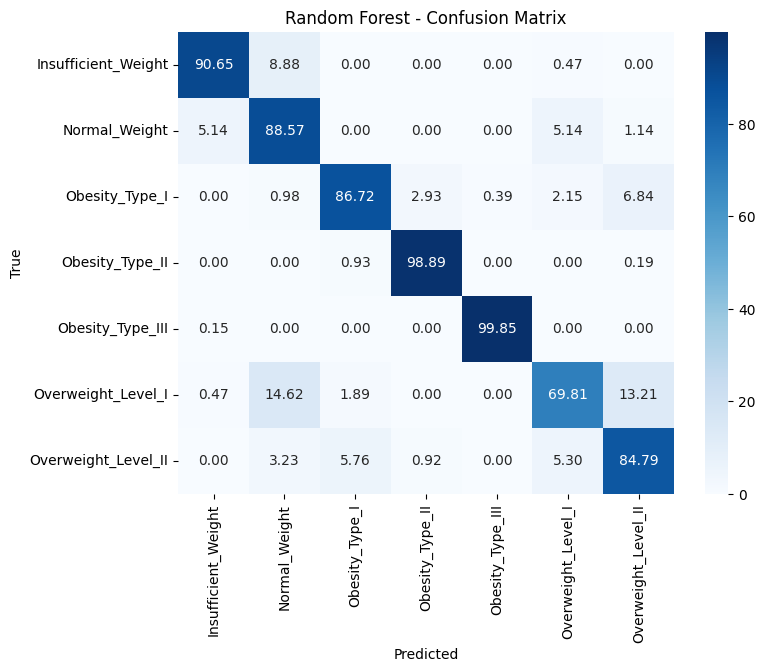


==================== AdaBoost ====================
Cross-Validation Accuracy: 0.7247
Validation Accuracy: 0.7633
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       428
           1       0.59      0.64      0.61       525
           2       0.74      0.76      0.75       512
           3       0.89      0.91      0.90       540
           4       0.95      1.00      0.97       661
           5       0.68      0.44      0.54       424
           6       0.66      0.67      0.67       434

    accuracy                           0.76      3524
   macro avg       0.75      0.74      0.74      3524
weighted avg       0.76      0.76      0.76      3524



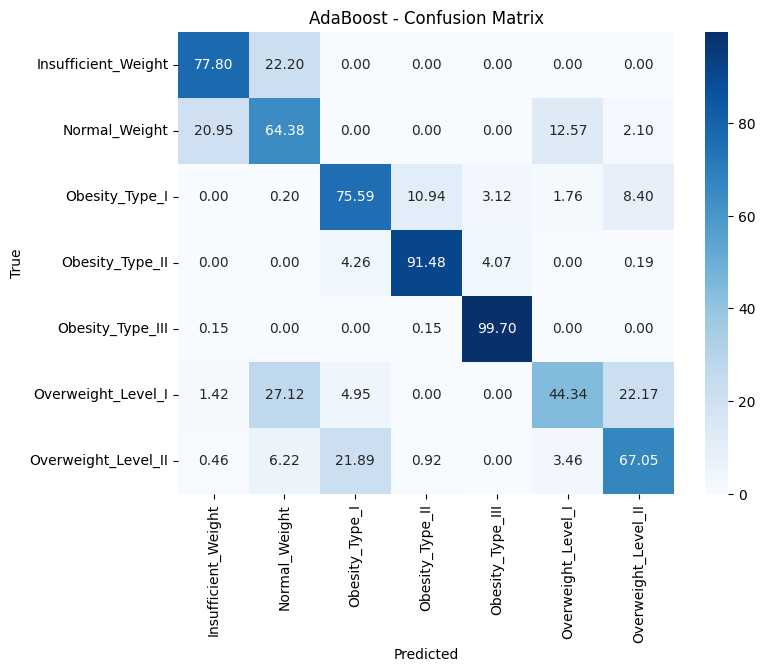


==================== Gradient Boosting ====================
Cross-Validation Accuracy: 0.9034
Validation Accuracy: 0.9078
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       428
           1       0.86      0.88      0.87       525
           2       0.91      0.91      0.91       512
           3       0.96      0.98      0.97       540
           4       1.00      1.00      1.00       661
           5       0.79      0.75      0.77       424
           6       0.84      0.82      0.83       434

    accuracy                           0.91      3524
   macro avg       0.90      0.90      0.90      3524
weighted avg       0.91      0.91      0.91      3524



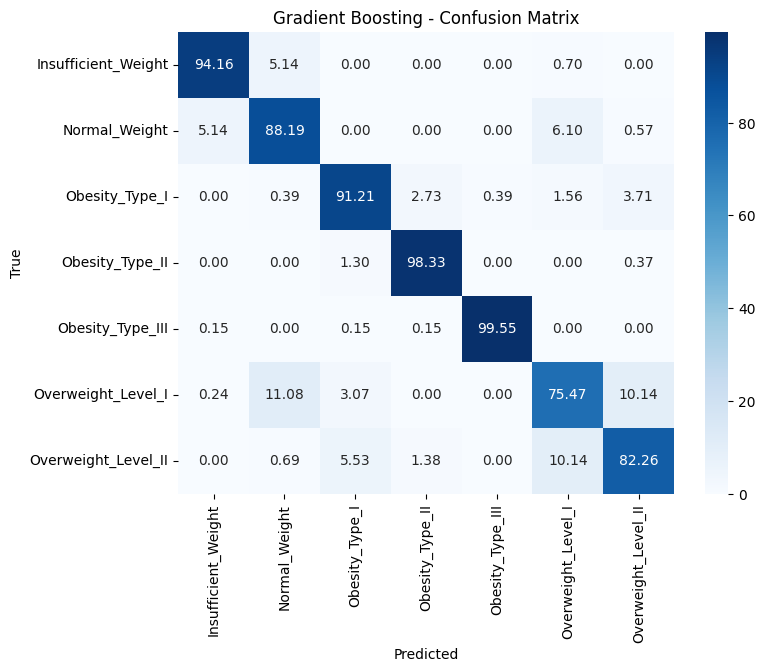

In [37]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Define best parameters for each model
# -------------------------------
rf_params = {
    'n_estimators': 1424,
    'max_depth': 12,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'bootstrap': False
}

ada_params = {
    'n_estimators': 1495,
    'learning_rate': 0.07597457794162066,
    'algorithm': 'SAMME'
}

gb_params = {
    'n_estimators': 1207,
    'learning_rate': 0.06517338247933074,
    'max_depth': 11,
    'min_samples_split': 6,
    'min_samples_leaf': 1,
    'subsample': 0.8101963465846417
    # removed 'max_features': 'sqrt' (not supported by GradientBoosting in sklearn < 1.4)
}


# -------------------------------
# Model dictionary for iteration
# -------------------------------
models = {
    "Random Forest": RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(**ada_params, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(**gb_params, random_state=42)
}

# -------------------------------
# Preprocess data
# -------------------------------
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# -------------------------------
# Train and evaluate each model
# -------------------------------
for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")

    # Cross-validation accuracy
    cv_score = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    print(f"Cross-Validation Accuracy: {cv_score:.4f}")

    # Train the model
    model.fit(X_train_processed, y_train)

    # Predictions
    y_pred = model.predict(X_val_processed)
    y_pred = y_pred.astype(int)

    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


In [43]:
# # Assuming 'final_pipeline' which includes the preprocessor and the best XGBoost model
# # is already trained on the full training data (X, y)

# # Prepare the test data (drop 'id')
# X_test = test_df.drop('id', axis=1)
# test_ids = test_df['id']

# # Make predictions on the test set using the final pipeline
# test_predictions_encoded = final_pipeline.predict(X_test)

# # Decode the numeric predictions back into string labels using the fitted LabelEncoder
# test_predictions_labels = le.inverse_transform(test_predictions_encoded)

# # Create the submission DataFrame
# submission_df = pd.DataFrame({
#     'id': test_ids,
#     'WeightCategory': test_predictions_labels
# })

# # Save to CSV
# submission_df.to_csv('submission.csv', index=False)

# print("\n--- 'submission.csv' created successfully! ---")
# print("Submission file head:")
# print(submission_df.head())

In [42]:
# --- Compute Validation Accuracy for Best Model ---
best_model = ModelClass(**study.best_params)
best_model.fit(preprocessor.transform(X_train), y_train)
val_preds = best_model.predict(preprocessor.transform(X_val))
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Accuracy on validation set: {val_accuracy:.5f}")

# --- Train Final Model on All Data ---
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ModelClass(**study.best_params))
])
final_pipeline.fit(X, y)
print("Final model training complete.")

# --- Generate Submission CSV ---
# Assumes test_df exists and has an 'id' column
X_test = test_df.drop('id', axis=1)
test_ids = test_df['id']
test_preds_encoded = final_pipeline.predict(X_test) # Get the encoded predictions
test_preds_labels = le.inverse_transform(test_preds_encoded) # Decode the predictions

submission_df = pd.DataFrame({'id': test_ids, 'WeightCategory': test_preds_labels}) # Use the decoded labels
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' generated.")


In [22]:
!kaggle competitions submit -c ait-511-course-project-1-obesity-risk -f submission.csv -m "Submission using original data"

100% 118k/118k [00:00<00:00, 335kB/s]
Successfully submitted to AIT511: Course Project 1

In [ ]:
------------------------------------------------------------#FINAL TRAIN AND TEST ACCURACIES------------------------------------------------------------------

In [ ]:
#Random Forest -------- #test accuracy -- Score: 89.366
  # Best Accuracy train: 0.89529
  # Best Hyperparameters: {'n_estimators': 1424, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}

#Adaboost ------- #test accuracy -- Score:76.942
  # --- Optimization Complete ---
  #   Best Accuracy: 0.76334
  #   Best Hyperparameters: {'n_estimators': 1495, 'learning_rate': 0.07597457794162066, 'algorithm': 'SAMME'}

#Gradient Boost ------- train accuracy: 91.175  #test accuracy -- Score: Score: 0.90082
    #--- Optimization Complete ---
    #   Best Accuracy: 0.91175
    #  Best Hyperparameters: {'n_estimators': 1207, 'learning_rate': 0.06517338247933074, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.8101963465846417, 'max_features': 'sqrt'}

#XG Boost ------- #test accuracy -- Score:91.542
    # Best Validation Accuracy: 0.92509
    # Best Hyperparameters:
    # {'n_estimators': 1597, 'learning_rate': 0.01452211141490541, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 0.6985265792741071, 'subsample': 0.7050056223404357, 'colsample_bytree': 0.4686281411833096, 'reg_alpha': 0.5740823340642535, 'reg_lambda': 0.832267917170442}